# Распознавание цифр MNIST на PyTorch (1.5–2 часа)
**Тема:** строим свою нейросеть для распознавания рукописных цифр `0..9` из датасета **MNIST**.  
**Формат:** большой, лёгкий, понятный урок (много объяснений) + в конце **10 заданий** на дописывание кода.

---

## Что мы сделаем за урок (как mini‑проект)
1) Скачаем MNIST через `torchvision`
2) Посмотрим примеры изображений и поймём формат данных
3) Подготовим `DataLoader` (батчи)
4) Напишем модель **MLP** (простая полносвязная сеть)
5) Напишем цикл обучения (**forward → loss → backward → step**)
6) Оценим качество (accuracy + confusion matrix)
7) Сохраним модель и загрузим обратно
8) Протестируем на отдельных картинках

> Мы используем **MLP** (самый понятный вариант). В конце упомянем, почему CNN лучше.

---
## Тайминг (ориентировочно)
- 0–10 мин: что такое MNIST, задача, данные  
- 10–30 мин: загрузка + визуализация + DataLoader  
- 30–55 мин: модель MLP и нелинейность  
- 55–85 мин: обучение (loss/optimizer/train loop)  
- 85–105 мин: оценка (accuracy/confusion matrix)  
- 105–115 мин: сохранение/загрузка модели  
- 115–120 мин: задания  


In [5]:
# Если torch/torchvision не установлен (обычно в Colab всё есть):
# !pip install torch torchvision --quiet

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, classification_report

import torchvision
from torchvision import datasets, transforms

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("device:", device)


torch: 2.9.1+cpu
torchvision: 0.24.1+cpu
device: cpu


# 1) MNIST: что это?
- Картинки 28×28 (серые)
- Классы 0..9
- Train 60k / Test 10k


# 2) Загрузка данных + transforms
Мы делаем:
- `ToTensor()` → (1, 28, 28), значения 0..1
- `Normalize(mean, std)` → помогает обучению


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

print("train size:", len(train_ds))
print("test size :", len(test_ds))

img0, y0 = train_ds[0]
print("img shape:", img0.shape, "label:", y0)


# 3) Визуализация примеров

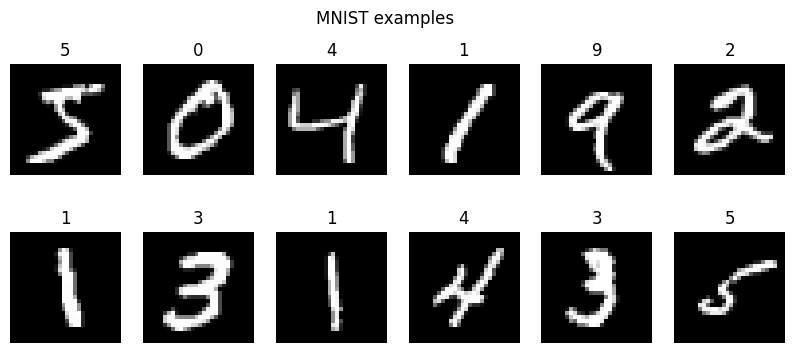

In [7]:
def show_batch(dataset, n=12):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        img, label = dataset[i]
        plt.subplot(2, 6, i+1)
        plt.imshow(img.squeeze(0), cmap="gray")
        plt.title(str(label))
        plt.axis("off")
    plt.suptitle("MNIST examples")
    plt.show()

show_batch(train_ds, 12)


# 4) DataLoader (батчи)

In [8]:
BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False)

Xb, yb = next(iter(train_loader))
print("X batch:", Xb.shape)
print("y batch:", yb.shape)


X batch: torch.Size([128, 1, 28, 28])
y batch: torch.Size([128])


# 5) Модель: MLP
Flatten 28×28 → 784, затем 784→256→128→10.
Выход **logits** (не softmax!).


In [9]:
class MNIST_MLP(nn.Module):
    def __init__(self, hidden1=256, hidden2=128):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)     # Flatten -> (batch, 784)
        x = F.relu(self.fc1(x))       # (batch, 256)
        x = F.relu(self.fc2(x))       # (batch, 128)
        logits = self.fc3(x)          # (batch, 10)
        return logits

model = MNIST_MLP().to(device)
print(model)
print("params:", sum(p.numel() for p in model.parameters()))


MNIST_MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)
params: 235146


# 6) Loss + Optimizer
- CrossEntropyLoss: для 10 классов
- Adam: хороший старт


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(type(criterion).__name__, type(optimizer).__name__)


CrossEntropyLoss Adam


# 7) Train/Eval функции

In [11]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    return total_loss / len(loader.dataset), correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_true = []

    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)

        total_loss += loss.item() * Xb.size(0)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)
    return total_loss / len(loader.dataset), correct / total, y_true, y_pred


# 8) Обучение (несколько эпох)

In [12]:
EPOCHS = 5
history = []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    te_loss, te_acc, _, _ = evaluate(model, test_loader, criterion, device)
    history.append((epoch, tr_loss, tr_acc, te_loss, te_acc))
    print(f"epoch={epoch:02d} | train loss={tr_loss:.4f} acc={tr_acc:.4f} | test loss={te_loss:.4f} acc={te_acc:.4f}")

history


epoch=01 | train loss=0.2692 acc=0.9188 | test loss=0.1323 acc=0.9609
epoch=02 | train loss=0.1030 acc=0.9681 | test loss=0.0922 acc=0.9715
epoch=03 | train loss=0.0696 acc=0.9783 | test loss=0.0824 acc=0.9743
epoch=04 | train loss=0.0513 acc=0.9834 | test loss=0.0765 acc=0.9788
epoch=05 | train loss=0.0407 acc=0.9871 | test loss=0.0700 acc=0.9787


[(1, 0.26920918331146243, 0.9187833333333333, 0.13228543267250062, 0.9609),
 (2, 0.10298718494971593, 0.9681333333333333, 0.0922338816165924, 0.9715),
 (3, 0.06963471370438734, 0.9782666666666666, 0.0824446830034256, 0.9743),
 (4, 0.05127268394629161, 0.9833833333333334, 0.07650056090354919, 0.9788),
 (5, 0.040651501211524006, 0.9871, 0.06996114096641541, 0.9787)]

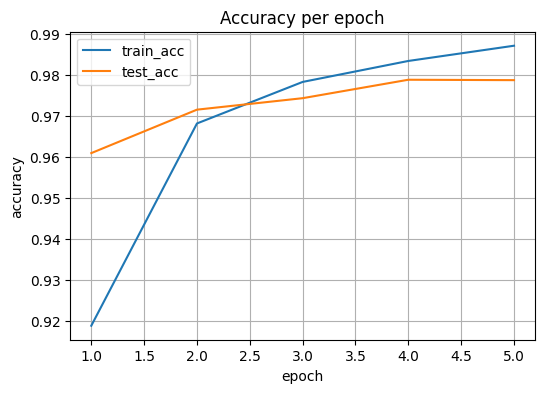

In [13]:
# График accuracy
hist = np.array(history, dtype=float)
epochs = hist[:,0]
train_acc = hist[:,2]
test_acc = hist[:,4]

plt.figure(figsize=(6,4))
plt.plot(epochs, train_acc, label="train_acc")
plt.plot(epochs, test_acc, label="test_acc")
plt.title("Accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True)
plt.legend()
plt.show()


# 9) Confusion matrix + report

Test accuracy: 0.9787
Report:
               precision    recall  f1-score   support

           0      0.970     0.994     0.982       980
           1      0.987     0.992     0.989      1135
           2      0.982     0.973     0.978      1032
           3      0.985     0.978     0.982      1010
           4      0.974     0.973     0.973       982
           5      0.976     0.974     0.975       892
           6      0.988     0.966     0.977       958
           7      0.981     0.982     0.981      1028
           8      0.976     0.975     0.976       974
           9      0.966     0.978     0.972      1009

    accuracy                          0.979     10000
   macro avg      0.979     0.978     0.978     10000
weighted avg      0.979     0.979     0.979     10000



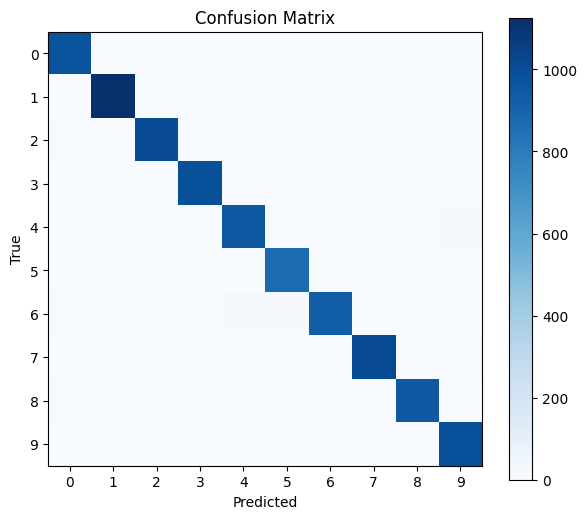

In [14]:
te_loss, te_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device)
print("Test accuracy:", te_acc)

cm = confusion_matrix(y_true, y_pred)
print("Report:\n", classification_report(y_true, y_pred, digits=3))

plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()


# 10) Посмотрим ошибки модели

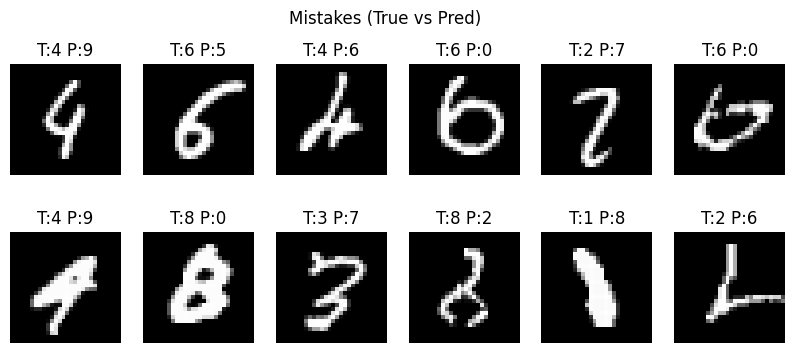

In [15]:
@torch.no_grad()
def show_mistakes(model, dataset, device, n=12):
    model.eval()
    plt.figure(figsize=(10,4))
    shown = 0
    i = 0
    while shown < n and i < len(dataset):
        img, true_label = dataset[i]
        X = img.unsqueeze(0).to(device)
        logits = model(X)
        pred = torch.argmax(logits, dim=1).item()
        if pred != true_label:
            plt.subplot(2, 6, shown+1)
            plt.imshow(img.squeeze(0), cmap="gray")
            plt.title(f"T:{true_label} P:{pred}")
            plt.axis("off")
            shown += 1
        i += 1
    plt.suptitle("Mistakes (True vs Pred)")
    plt.show()

show_mistakes(model, test_ds, device, n=12)


# 11) Save/Load model

In [ ]:
MODEL_PATH = "mnist_mlp_state_dict.pt"
torch.save(model.state_dict(), MODEL_PATH)
print("Saved:", MODEL_PATH)

model_loaded = MNIST_MLP().to(device)
model_loaded.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model_loaded.eval()

te_loss2, te_acc2, _, _ = evaluate(model_loaded, test_loader, criterion, device)
print("Loaded model test acc:", te_acc2)


# 12) Предсказание на одной картинке

In [ ]:
import random

idx = random.randint(0, len(test_ds)-1)
img, true_label = test_ds[idx]

plt.figure(figsize=(3,3))
plt.imshow(img.squeeze(0), cmap="gray")
plt.title(f"True: {true_label}")
plt.axis("off")
plt.show()

with torch.no_grad():
    X = img.unsqueeze(0).to(device)
    logits = model_loaded(X)
    probs = torch.softmax(logits, dim=1).cpu().numpy().reshape(-1)
    pred = int(np.argmax(probs))

print("Predicted:", pred)
print("Top-3:", np.argsort(probs)[-3:][::-1], np.sort(probs)[-3:][::-1])


---
# 10 заданий (дополнить код)
Формат: **задание → подсказка → код с пропусками `_____`**


## Задание 1

**Задание:** Соберите transform: ToTensor + Normalize.

**Подсказка:** transforms.Compose([...])


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.toTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

transform


## Задание 2

**Задание:** Загрузите MNIST train/test.

**Подсказка:** datasets.MNIST(...)


In [17]:
from torchvision import datasets

train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

print(len(train_ds), len(test_ds))


60000 10000


## Задание 3

**Задание:** Сделайте DataLoader.

**Подсказка:** DataLoader(dataset, batch_size, shuffle)


In [18]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

Xb, yb = next(iter(train_loader))
print(Xb.shape, yb.shape)


torch.Size([64, 1, 28, 28]) torch.Size([64])


## Задание 4

**Задание:** Допишите forward (Flatten + ReLU).

**Подсказка:** x.view + F.relu


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StudentMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

m = StudentMLP(); print(m)


StudentMLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


## Задание 5

**Задание:** Создайте criterion + optimizer.

**Подсказка:** CrossEntropyLoss + Adam


In [20]:
import torch
import torch.nn as nn

model = StudentMLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(type(criterion).__name__, type(optimizer).__name__)


CrossEntropyLoss Adam


## Задание 6

**Задание:** Сделайте один шаг обучения на батче.

**Подсказка:** zero_grad/backward/step


In [22]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StudentMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Xb, yb = next(iter(train_loader))
Xb = Xb.to(device)
yb = yb.to(device)

logits = model(Xb)
loss = criterion(logits, yb)

optimizer.zero_grad()
loss.backward()
optimizer.step()

print("loss:", loss.item())


loss: 2.304389238357544


## Задание 7

**Задание:** Посчитайте accuracy батча.

**Подсказка:** argmax(dim=1)


In [23]:
import torch

preds = torch.argmax(logits, dim=1)
acc = (preds == yb).float().mean().item()
print("batch acc:", acc)


batch acc: 0.09375


## Задание 8

**Задание:** Напишите evaluate_student: model.eval() + no_grad.

**Подсказка:** верните accuracy на test_loader


In [25]:
from sklearn.metrics import accuracy_score
import numpy as np
import torch

@torch.no_grad()
def evaluate_student(model, loader, device):
    model.eval()
    all_preds, all_true = [], []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(yb.numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)
    return accuracy_score(y_true, y_pred)

acc = evaluate_student(model, test_loader, device)
print("test acc:", acc)


test acc: 0.1945


## Задание 9

**Задание:** Сохраните и загрузите state_dict.

**Подсказка:** torch.save + load_state_dict


In [26]:
import torch

path = "tmp_mnist.pt"
torch.save(model.state_dict(), path)

model2 = StudentMLP().to(device)
model2.load_state_dict(torch.load(path, map_location=device))
model2.eval()
print("loaded ok")


loaded ok


## Задание 10

**Задание:** Выведите 8 ошибок модели на тесте.

**Подсказка:** рисуем картинки и подписи T/P


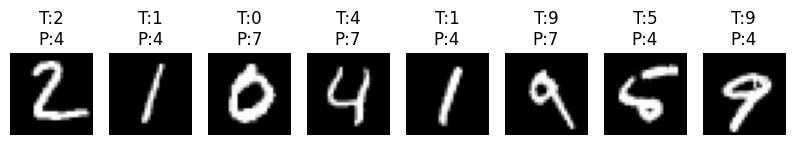

In [27]:
import matplotlib.pyplot as plt
import torch

model.eval()
shown = 0
i = 0

plt.figure(figsize=(10,3))
while shown < 8 and i < len(test_ds):
    img, true_label = test_ds[i]
    X = img.unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(X)
        pred = torch.argmax(logits, dim=1).item()
    if pred != true_label:
        plt.subplot(1, 8, shown+1)
        plt.imshow(img.squeeze(0), cmap="gray")
        plt.title(f"T:{true_label}\nP:{pred}")
        plt.axis("off")
        shown += 1
    i += 1

plt.show()
